# SIV PROJECT - CLASSIFICATION OF SHIP FROM SAR IMAGES

## PRE-PROCESSING PHASE


In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt

In [2]:
from skimage import img_as_float

# Show multiple images
def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax)
        ax.set_title(label)

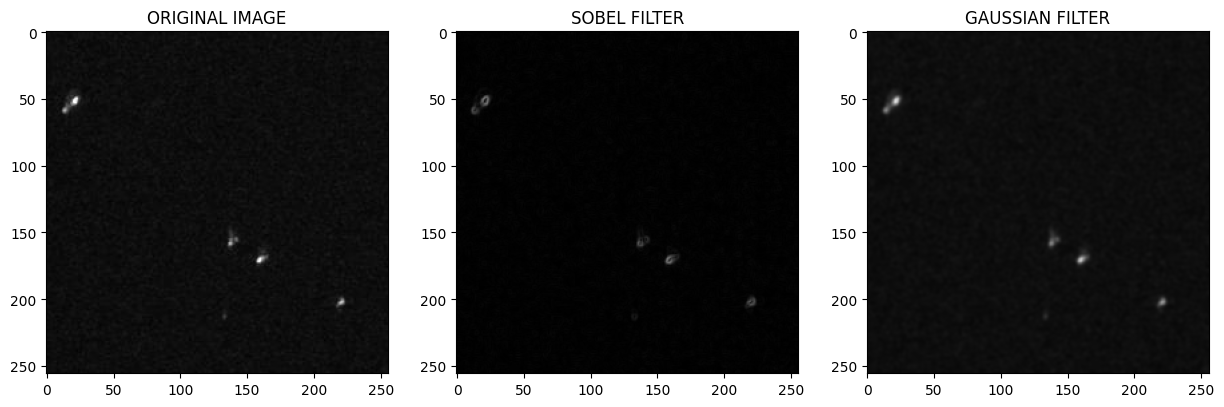

In [3]:
# in this file there are 4 ships
BASE_DIR = './ship_dataset_v0/'

from skimage import filters


file = 'ship030608.jpg'
example_image=cv2.imread(BASE_DIR+file)

# gaussian is not good for what we want to achieve, we need to enchance the bright colors...
imshow_all(example_image, filters.sobel(example_image), filters.gaussian(example_image), titles=["ORIGINAL IMAGE", "SOBEL FILTER", "GAUSSIAN FILTER"])



# we want also to precise in the shore since the difficulty to detect sea and land and then performing the classification comes from that

(256, 256, 3)


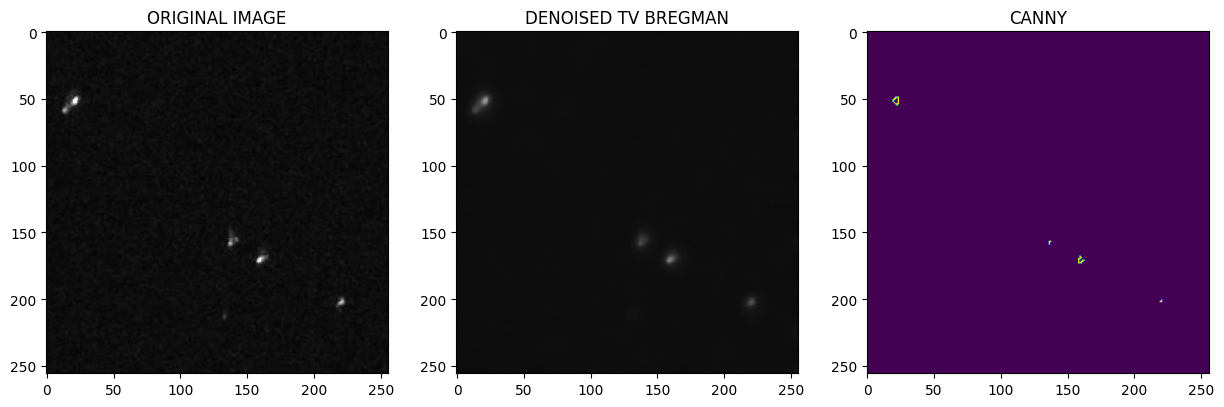

In [4]:
# other denoise filters

from skimage.restoration import denoise_tv_bregman
from skimage.morphology import disk
denoised = denoise_tv_bregman(example_image, 1)
d = disk(4)
#median = filters.rank.median(example_image, d)
titles = ['image', 'denoised', 'canny']

#canny
edges = cv2.Canny(example_image,600
                  ,750)

print(denoised.shape)

imshow_all(example_image, denoised, edges, titles=["ORIGINAL IMAGE",  "DENOISED TV BREGMAN", "CANNY"])





In [5]:
import glob

# Replace 'path/to/directory' with the directory path where your .jpg files are located
jpg_files = glob.glob(BASE_DIR +'*.jpg')

#print(jpg_files)

Random JPG file selected: ./ship_dataset_v0\Gao_ship_vh_020161130160203306.jpg
./ship_dataset_v0\Gao_ship_vh_020161130160203306.txt
Contents of the file:
0 0.02734375 0.10546875 0.0546875 0.109375

(256, 256, 3)
['./ship_dataset_v0\\Gao_ship_vh_020161130160203306.jpg', 'denoised', 'canny']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random JPG file selected: ./ship_dataset_v0\Gao_ship_hh_0201608254401011052.jpg
./ship_dataset_v0\Gao_ship_hh_0201608254401011052.txt
Contents of the file:
0 0.90625 0.71484375 0.0703125 0.0546875

(256, 256, 3)
['./ship_dataset_v0\\Gao_ship_hh_0201608254401011052.jpg', 'denoised', 'canny']


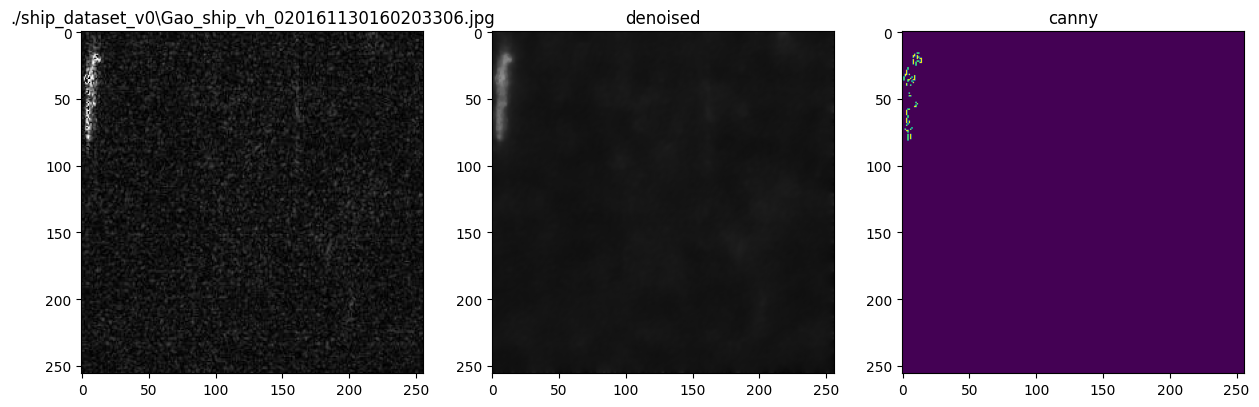

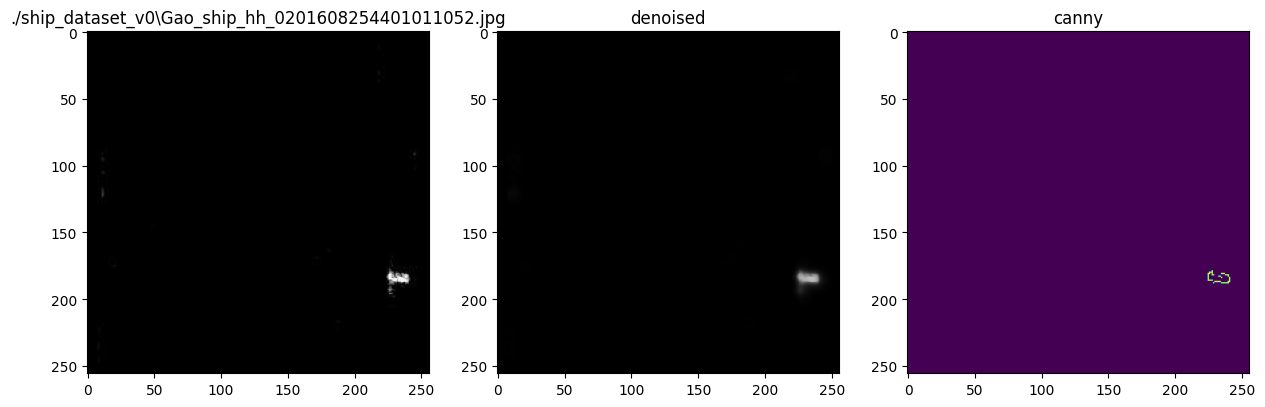

In [6]:
import os 
import random

# function to take a random file from the folder and applying canny transformation
def get_random_jpg_file():
    # pick random number from 0 to jpg_files.length
    
    if not jpg_files:
        print("No JPG files found in the folder.")
        return None
    
    random_jpg = random.choice(jpg_files)
    return os.path.join(random_jpg)

n_times = 2

for i in range(0, n_times):
    random_jpg_file = get_random_jpg_file()

    if random_jpg_file:
        print(f"Random JPG file selected: {random_jpg_file}")

        txt_file = random_jpg_file.replace(".jpg", ".txt")
        print(txt_file)
        with open(txt_file, 'r') as file:
            file_content = file.read()
            print("Contents of the file:")
            print(file_content)

        image=cv2.imread(random_jpg_file)
        denoised = denoise_tv_bregman(image, 1)
        d = disk(4)
        #median = filters.rank.median(example_image, d)
        titles = [random_jpg_file, 'denoised', 'canny']


        #canny
        # this parameters can be modified we have problems when we are dealing with a harbour and coastal areas 
        edges = cv2.Canny(image,600,750)

        print(denoised.shape)

        print(titles)
        imshow_all(image, denoised, edges, titles=titles)

In [39]:
img = cv2.imread('./ship_dataset_v0/Gao_ship_hh_020170405960306013.jpg')
dst = cv2.fastNlMeansDenoising(img, None, 10)

# convert to gray
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# blur
#smooth = cv2.GaussianBlur(gray, (8,8), 0)

# smooth with bilateral filter to remove noise 
# https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed
smooth = cv2.bilateralFilter(img, 50, 200, 200)
# divide gray by morphology image
#division = cv2.divide(gray, smooth, scale=255)

canny_before = cv2.Canny(gray, 600, 750)
canny = cv2.Canny(smooth, 600, 750)

#sharp = filters.unsharp_mask(division, radius=1.5, amount=1.5, multichannel=False, preserve_range=False)
#sharp = (255*sharp).clip(0,255).astype(np.uint8)
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

test = denoise_bilateral(img, sigma_color=0.50, sigma_spatial=10,
                channel_axis=-1)

# TODO: try to use the canny on the test image
canny_on_test = cv2.Canny(test, 600, 750)
imshow_all(img, canny_before, dst, smooth, canny, canny_on_test)




#plt.subplot(154),plt.imshow(division)
#plt.subplot(155),plt.imshow(sharp)

plt.show()

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\canny.cpp:829: error: (-215:Assertion failed) _src.depth() == CV_8U in function 'cv::Canny'


In [31]:
# TODO: given the latter we need to asses when the bilater filter is actually necessary and when it is not
# so we need to respond actually to this question: when we can define an image noisy?

## CNN / Mask R-CNN / Faster R-CNN with object detection

In order to perform the detection after the pre-processing phase we are going to use the images to train a model and compute where the ship are inside the image.
In the final part we will discuss about the result of the CNN comparing the result using the two training dataset (the pre-processed one and the original dataset) to see if the behaviour of the NN changes.

## RESULTS
